In [1]:
%load_ext autoreload
%autoreload 2

import collections
import logging
import os
import pathlib

import numpy as np
import pandas as pd

import core.config as cconfig
import core.dataflow as cdataf
import core.finance as cfina
import core.dataflow_model.model_evaluator as cmodel
import core.dataflow_model.model_plotter as modplot
import core.dataflow_model.utils as cdmu
import core.plotting as plot
import core.signal_processing as csigna
import dataflow_lemonade.futures_returns.pipeline as dlfrp
import helpers.dbg as dbg
import helpers.env as henv
import helpers.io_ as hio
import helpers.pickle_ as hpickl
import helpers.printing as hprint

from typing import Any, Dict, Iterable, Optional

from tqdm.auto import tqdm

/app/amp/core/dataflow/core.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
dbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

# _LOG.info("%s", henv.get_system_signature()[0])

# hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-cc30a7c1-d267-40d6-ac18-bbe52337a9ae.json'


In [3]:
def get_config_diffs(
    config_dict: collections.OrderedDict, tag_col: Optional[str] = None
) -> pd.DataFrame:
    """
    Create a dataframe of config diffs.

    :param config_dict: dictionary of configs
    :param tag_col: name of the tag col. If tags are the same for all configs
        and `tag_col` is not None, add tags to config diffs dataframe
    :return: config diffs dataframe
    """
    diffs = cconfig.diff_configs(config_dict.values())
    non_empty_diffs = [diff for diff in diffs if len(diff) > 1]
    if non_empty_diffs:
        config_diffs = cconfig.convert_to_dataframe(diffs).dropna(
            how="all", axis=1
        )
    else:
        config_diffs = pd.DataFrame(index=range(len(diffs)))
    # If tags are the same, still add them to `config_diffs`.
    if tag_col is not None and tag_col not in config_diffs.columns:
        tags = [config[tag_col] for config in config_dict.values()]
        config_diffs[tag_col] = tags
    return config_diffs

In [4]:
notebook_config = cconfig.get_config_from_nested_dict({
    "exp_dir": "/app/experiment1",
    "model_evaluator_kwargs": {
        "returns_col": "ret_0_vol_adj_2",
        "predictions_col": "ret_0_vol_adj_2_hat",
        "target_volatility": 0.1,
        "oos_start": "2017-01-01",
    },
})

# Load results

In [5]:
rbs_dicts = cdmu.load_experiment_artifacts(
    notebook_config["exp_dir"],
    "result_bundle.pkl"
)

# Load artifacts 'result_bundle.pkl' from '/app/experiment1'
Found 2 experiment subdirs in '/app/experiment1'
Loading '/app/experiment1/result_0/result_bundle.pkl'
Loading '/app/experiment1/result_1/result_bundle.pkl'


In [6]:
display(rbs_dicts[0]["result_df"].head(3))
display(rbs_dicts[0]["result_df"].tail(3))

,ret_0,ret_0_vol,ret_0_vol_2,ret_0_vol_2_hat,ret_0_vol_adj,ret_0_vol_adj_lag1,ret_0_vol_adj_lag2,ret_0_vol_adj_2,ret_0_vol_adj_2_hat
datetime,,,,,,,,,
2015-01-02 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02 04:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02 04:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,ret_0,ret_0_vol,ret_0_vol_2,ret_0_vol_2_hat,ret_0_vol_adj,ret_0_vol_adj_lag1,ret_0_vol_adj_lag2,ret_0_vol_adj_2,ret_0_vol_adj_2_hat
datetime,,,,,,,,,
2017-12-29 19:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-29 19:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-29 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
evaluator = cmodel.build_model_evaluator_from_result_bundle_dicts(
    rbs_dicts,
    **notebook_config["model_evaluator_kwargs"].to_dict(),
)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
evaluator.calculate_stats()

  0%|          | 0/2 [00:00<?, ?it/s]

,0,1
sharpe_ratio,1.579745,0.449647
sharpe_ratio_standard_error,0.706843,0.706847
tval,2.236668,0.636065
pval,0.025394,0.524792
kratio,0.498289,0.340734
annualized_mean_return_(%),15.797449,4.496474
annualized_volatility_(%),10.0,10.0
max_drawdown_(%),-8.0684,-8.147168
start_time,2016-06-30 10:45:00,2016-06-30 14:00:00
end_time,2016-12-30 15:30:00,2016-12-30 15:30:00


In [9]:
evaluator.aggregate_models(mode="ins", target_volatility=0.05)[2].to_frame()

,stats
sharpe_ratio,1.200158
sharpe_ratio_standard_error,0.706838
tval,1.698557
pval,0.089524
kratio,0.459911
annualized_mean_return_(%),6.000791
annualized_volatility_(%),5.0
max_drawdown_(%),-3.533987
start_time,2016-06-30 10:45:00
end_time,2016-12-30 15:30:00


In [10]:
evaluator.aggregate_models(mode="oos")[2].to_frame()

,stats
sharpe_ratio,1.897743
sharpe_ratio_standard_error,1.003181
tval,1.892218
pval,0.058519
kratio,1.616909
annualized_mean_return_(%),33.32144
annualized_volatility_(%),17.558461
max_drawdown_(%),-15.926328
start_time,2017-01-03 10:45:00
end_time,2017-12-29 15:30:00


In [11]:
evaluator.aggregate_models(mode="all_available")[2].to_frame()

,stats
sharpe_ratio,1.457839
sharpe_ratio_standard_error,0.578075
tval,2.522763
pval,0.011664
kratio,0.916632
annualized_mean_return_(%),17.941718
annualized_volatility_(%),12.307065
max_drawdown_(%),-15.926328
start_time,2016-06-30 10:45:00
end_time,2017-12-29 15:30:00


In [12]:
plotter = modplot.ModelPlotter(evaluator)

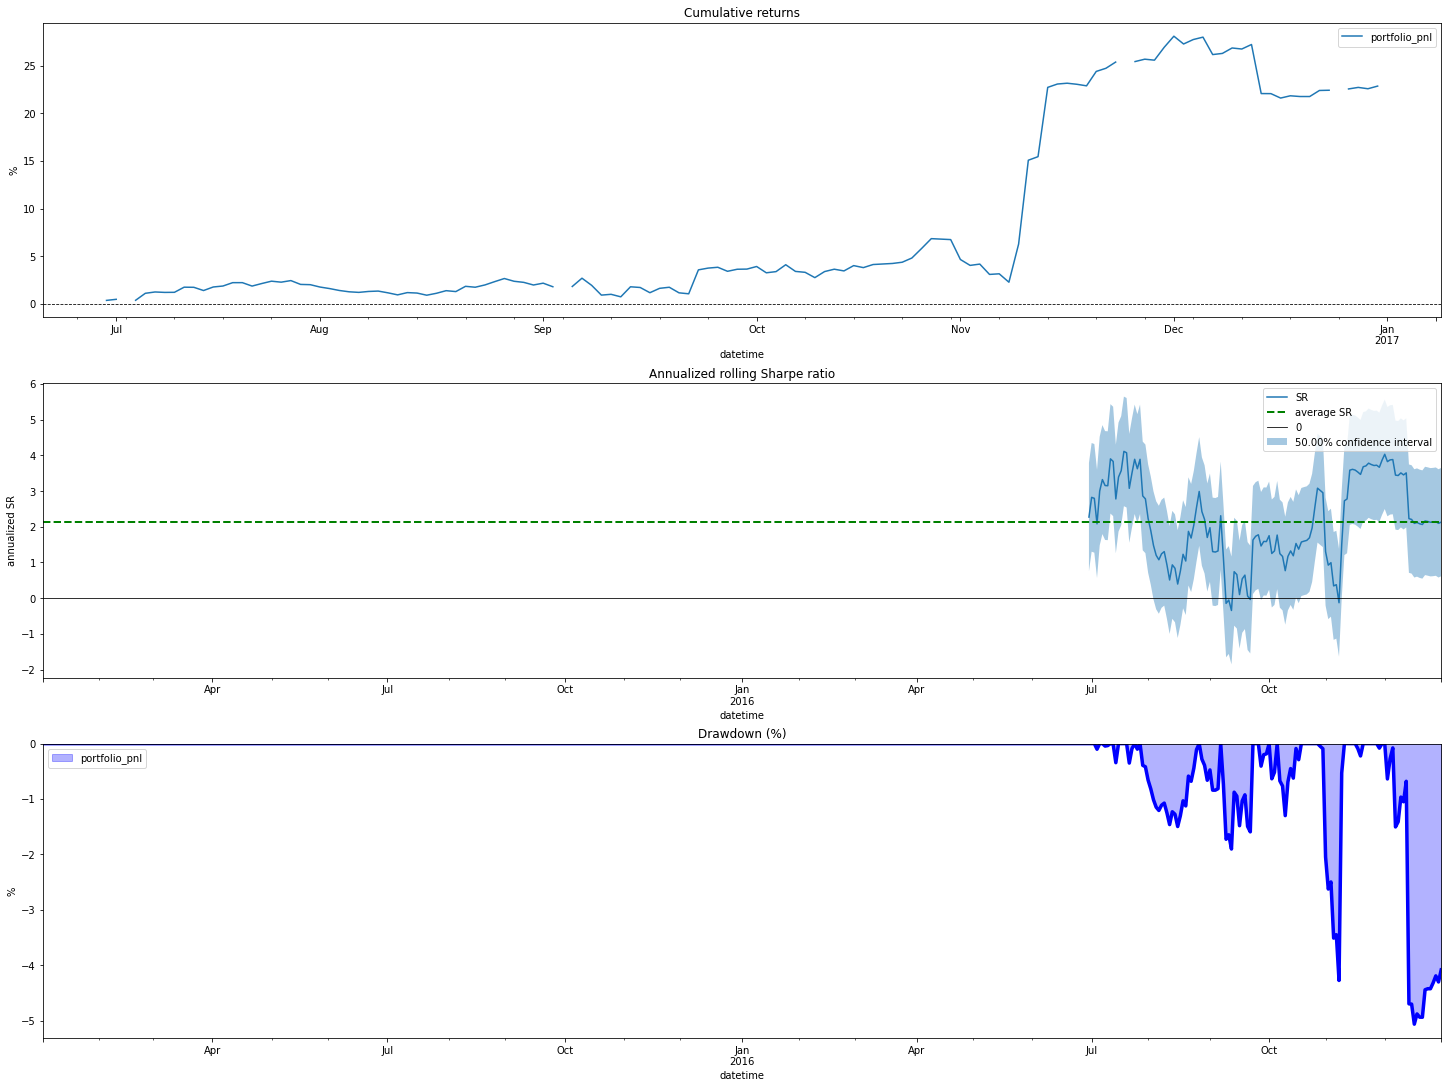

In [13]:
plotter.plot_performance(resample_rule="B")

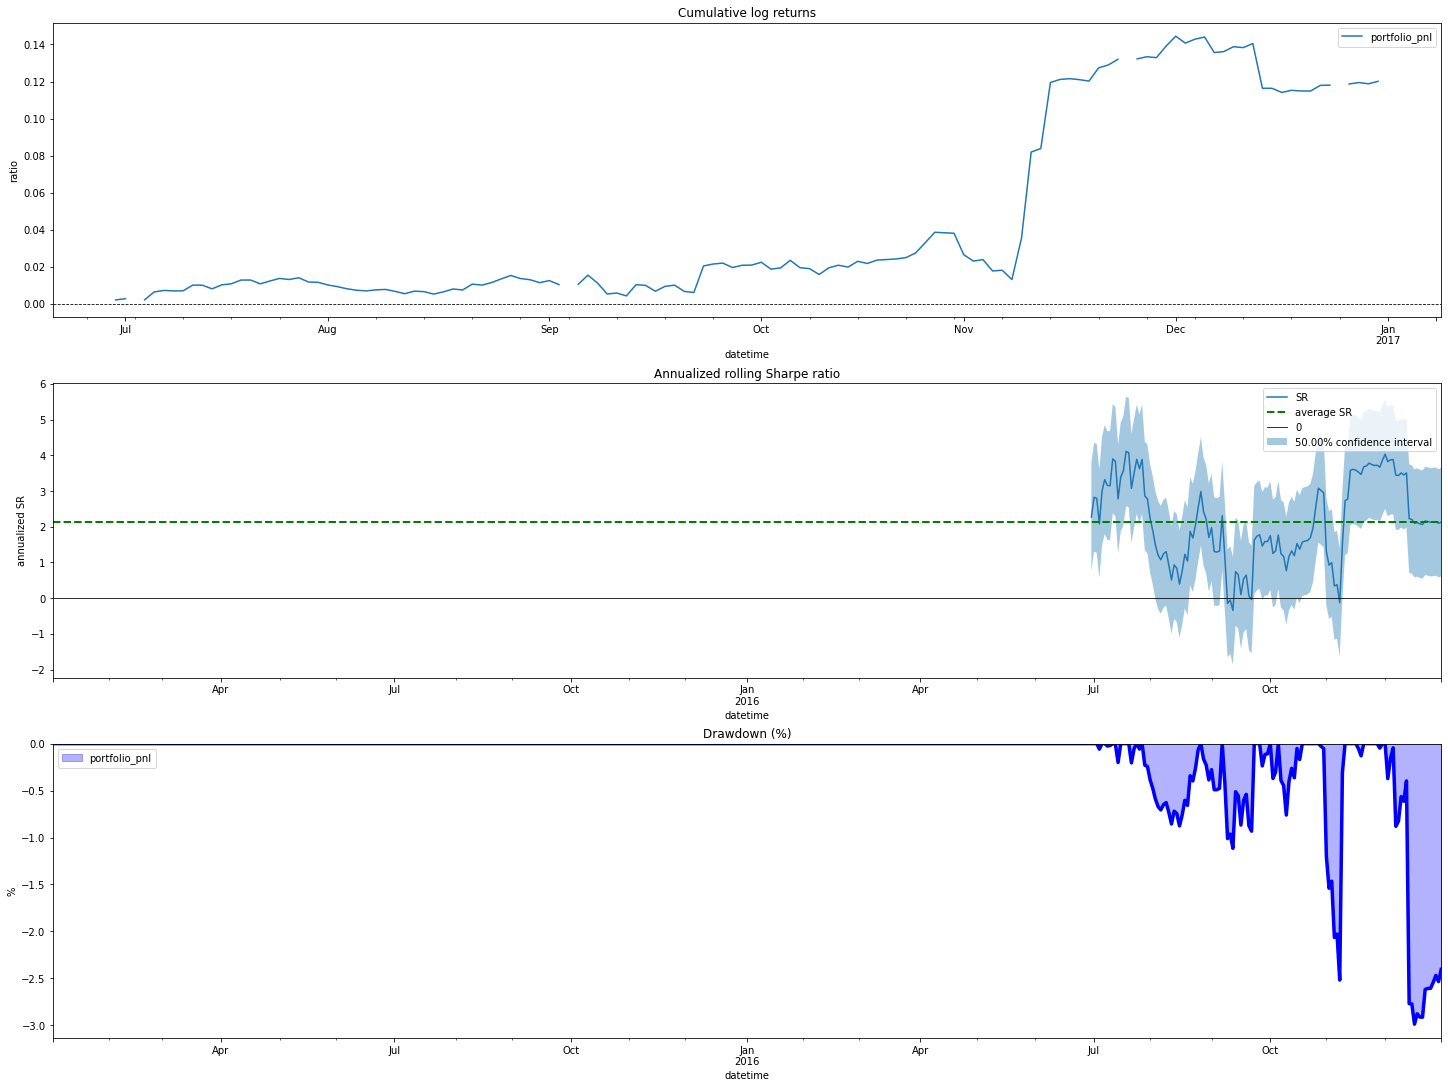

In [14]:
plotter.plot_performance(
    mode="ins",
    target_volatility=0.05,
    resample_rule="B",
    plot_cumulative_returns_kwargs={"mode": "log"},
)

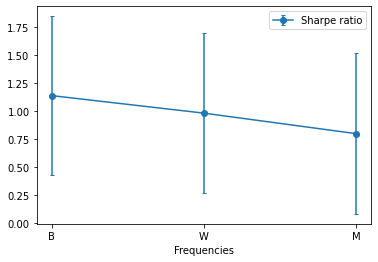

In [15]:
plotter.plot_sharpe_ratio_panel(frequencies=["B", "W", "M"])

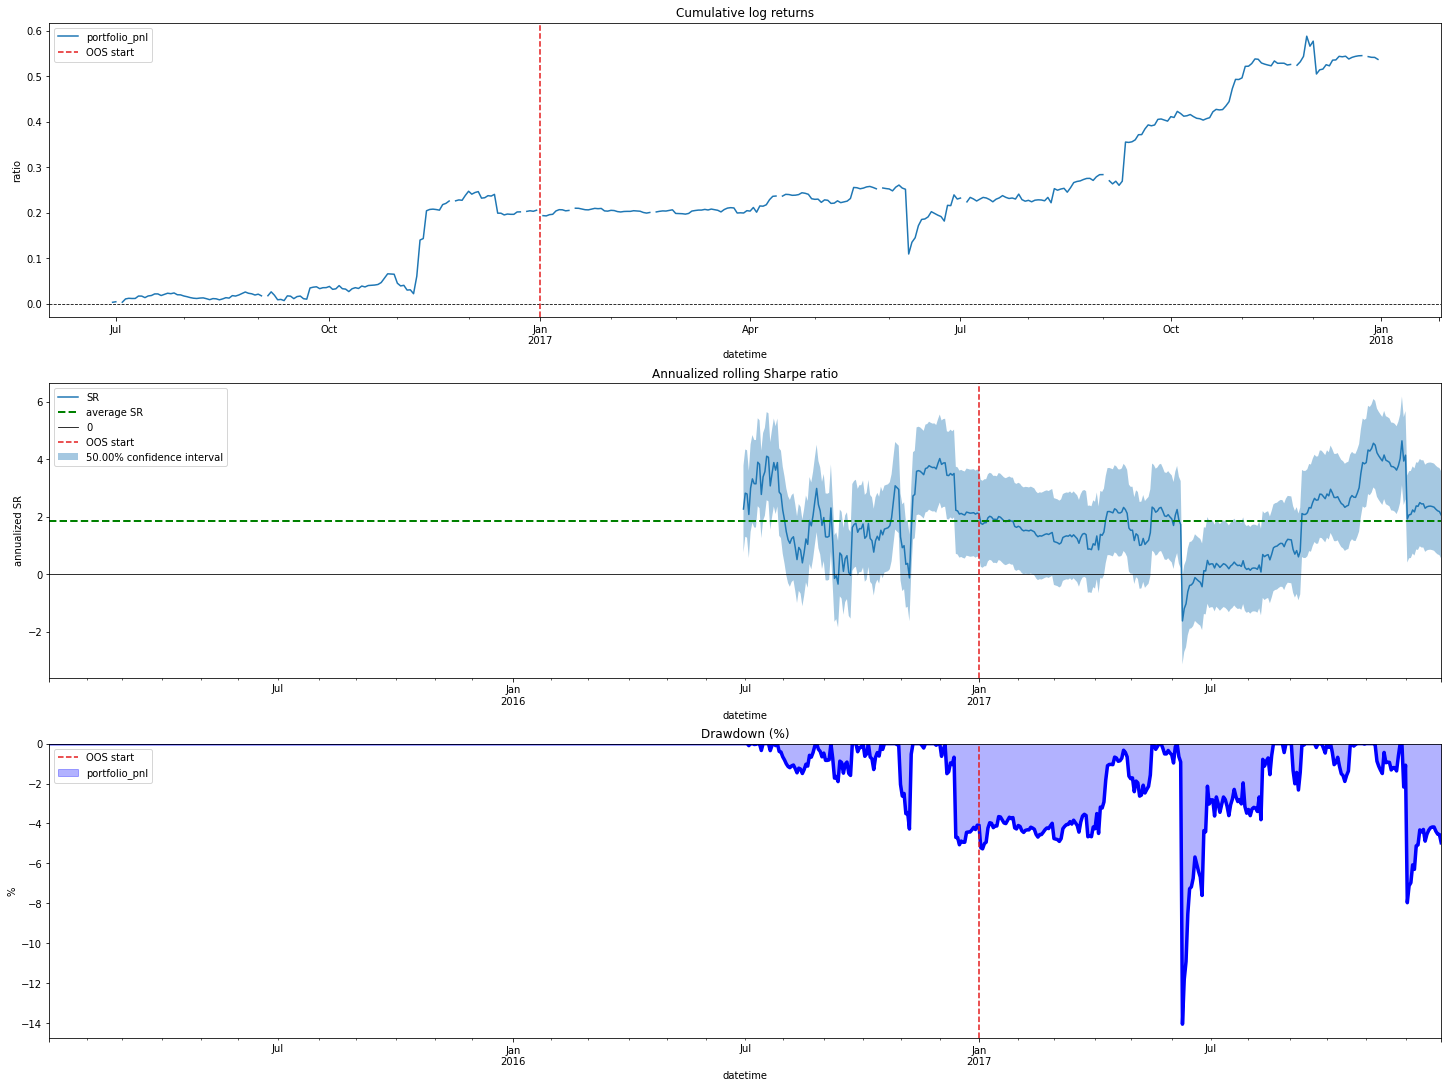

In [16]:
plotter.plot_performance(
    mode="all_available",
    target_volatility=0.05,
    resample_rule="B",
    plot_cumulative_returns_kwargs={"mode": "log"},
)